In [1]:
# note: fdfdpy and nonlinear_avm must be in PATH
from fdfdpy.Fdfd import Fdfd
from nonlinear_solvers import born_solve, newton_solve
from optimization import run_optimization, _solve_nl

import numpy as np
import matplotlib.pylab as plt
import scipy.sparse as sp

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
omega = 5e14                # angular frequency (2pi)
dl = 1e-1                   # grid size (m)
eps_r = np.ones((100,100))  # relative permittivity
eps_r[40:60, 40:60] = 5     # define box
NPML = [10, 10]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')

In [3]:
# sets simulation variables, constructs system matrix 'A', stored in 'simulation' object
simulation = Fdfd(omega,eps_r,dl,NPML,pol)

In [4]:
# set source and solve for electromagnetic fields
b = np.zeros((simulation.Nx,simulation.Ny))
b[40:60,30] = 1
(Hx,Hy,Ez) = simulation.solve_fields(b)

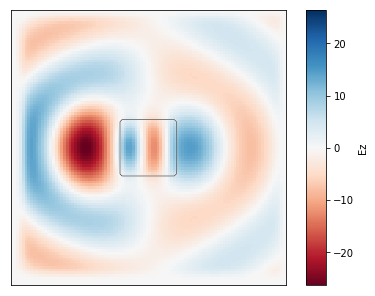

In [5]:
# plot linear field
simulation.plt_re(outline=True, cbar=True);

In [6]:
# Define some parameters for the optimization
eps_max = 5
Nsteps = 100
Jregion = np.zeros(eps_r.shape)
Jregion[50, 80] = 1
chi3 = 2.8*1e-18                           # Silcion in m^2/V^2 from Boyd's book
chi3_fdfd = chi3/simulation.L0**2          # In the units of the FDFD solver such that eps_nl = eps_r + 3*chi3_fdfd*|e|^2

## Purely Linear

In [7]:
# define linear and nonlinear parts of objective function + the total objective function form
J = {}
J['linear']    = lambda e: np.sum(np.square(np.abs(e*Jregion)))

# define linear and nonlinear parts of dJdE + the total derivative form
dJdE = {}
dJdE['linear']    = lambda e: np.conj(e)*Jregion

# define the design and nonlinear regions
design_region = np.array(eps_r > 1).astype(int)
regions = {}
regions['design'] = design_region

In [8]:
obj_fns = run_optimization(simulation, b, J, dJdE, Nsteps, eps_max, regions, nonlin_fns={}, field_start='linear', solver='born', step_size=0.1)

 99% (99 of 100) |###################### | Elapsed Time: 0:00:08 ETA:   0:00:00

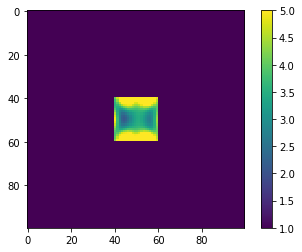

In [9]:
plt.imshow(simulation.eps_r)
plt.colorbar()
plt.show()

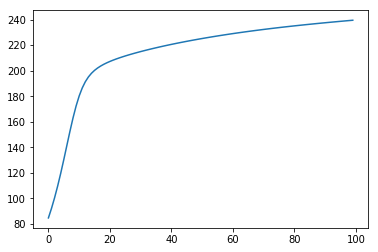

In [10]:
plt.plot(obj_fns)
plt.show()

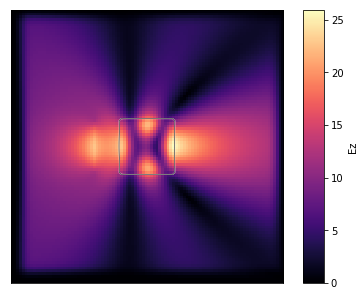

In [11]:
(Hx,Hy,Ez) = simulation.solve_fields(b)
simulation.plt_abs()

In [12]:
# Reset simulation
simulation.reset_eps(eps_r)

## Purely Nonlinear Optimization

In [13]:
# define linear and nonlinear parts of objective function + the total objective function form
J = {}
J['nonlinear'] = lambda e: np.sum(np.square(np.abs(e*Jregion)))

# define linear and nonlinear parts of dJdE + the total derivative form
dJdE = {}
dJdE['nonlinear'] = lambda e: np.conj(e)*Jregion

# define the design and nonlinear regions
design_region = np.array(eps_r > 1).astype(int)
regions = {}
regions['design'] = design_region
regions['nonlin'] = design_region

# define the nonlinearity
kerr_nonlinearity = lambda e: 3*chi3_fdfd*np.square(np.abs(e))
kerr_nl_de = lambda e: 3*chi3_fdfd*np.conj(e)
nonlin_fns = {}
nonlin_fns['deps_de'] = kerr_nonlinearity
nonlin_fns['dnl_de'] = kerr_nl_de

In [14]:
obj_fns = run_optimization(simulation, b, J, dJdE, Nsteps, eps_max, regions, 
                           nonlin_fns=nonlin_fns, field_start='linear', solver='born', step_size=0.1)

100% (100 of 100) |######################| Elapsed Time: 0:00:36 ETA:  00:00:00

In [15]:
# Note: takes a bit longer because the nonlinear solvers still need to solve twice to 
# know that the result is converged. Also the adjoint computation probably takes a bit longer
# Results look the same: 

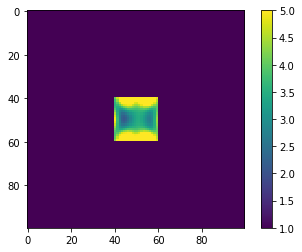

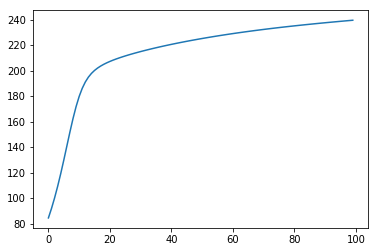

In [16]:
plt.imshow(simulation.eps_r)
plt.colorbar()
plt.show()
plt.plot(obj_fns)
plt.show()

In [17]:
# Reset simulation
simulation.reset_eps(eps_r)

## Both Linear and Nonlinear

In [18]:
# define linear and nonlinear parts of objective function + the total objective function form
J = {}
J['linear']    = lambda e: np.sum(np.square(np.abs(e*Jregion)))
J['nonlinear'] = lambda e: np.sum(np.square(np.abs(e*Jregion)))
J['total']     = lambda J_lin, J_nonlin: J_lin - J_nonlin

# define linear and nonlinear parts of dJdE + the total derivative form
dJdE = {}
dJdE['linear']    = lambda e: np.conj(e)*Jregion
dJdE['nonlinear'] = lambda e: np.conj(e)*Jregion
dJdE['total']     = lambda dJdE_lin, dJdE_nonlin: dJdE_lin - dJdE_nonlin

# define the design and nonlinear regions
design_region = np.array(eps_r > 1).astype(int)
regions = {}
regions['design'] = design_region
regions['nonlin'] = design_region

# define the nonlinearity
kerr_nonlinearity = lambda e: 3*chi3_fdfd*np.square(np.abs(e))
kerr_nl_de = lambda e: 3*chi3_fdfd*np.conj(e)
nonlin_fns = {}
nonlin_fns['deps_de'] = kerr_nonlinearity
nonlin_fns['dnl_de'] = kerr_nl_de

In [19]:
Nsteps_both = 100
obj_fns = run_optimization(simulation, 10*b, J, dJdE, Nsteps_both, eps_max, regions, nonlin_fns=nonlin_fns, field_start='linear', solver='born', step_size=0.005)

100% (100 of 100) |######################| Elapsed Time: 0:02:33 ETA:  00:00:00

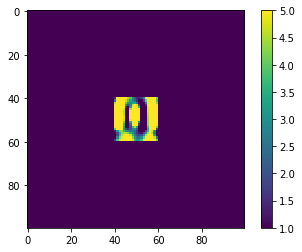

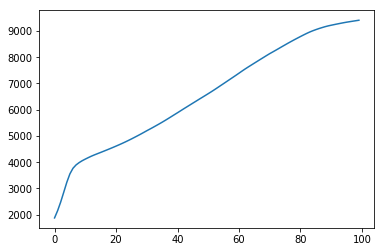

In [20]:
final_eps = simulation.eps_r
plt.imshow(final_eps)
plt.colorbar()
plt.show()
plt.plot(obj_fns)
plt.show()

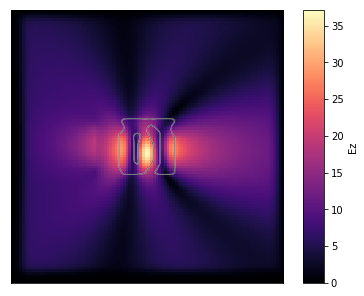

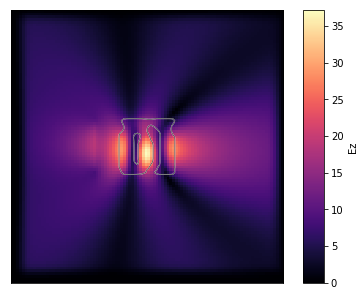

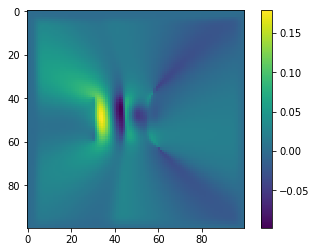

In [21]:
(Hx,Hy,Ez) = simulation.solve_fields(b)
simulation.plt_abs()

_ = _solve_nl(simulation, b, nonlin_fns['deps_de'], regions['nonlin'], nonlin_fns['dnl_de'], solver='born')
(Hx_nl,Hy_nl,Ez_nl) = simulation.solve_fields(b)

simulation.plt_abs()
plt.show()
plt.imshow(np.abs(Ez) - np.abs(Ez_nl))
plt.colorbar()

one can see from the last plot that the linear field is more intense at the measuring point, but only by a little bit.

## Nonlinear with larger input power

In [22]:
# define linear and nonlinear parts of objective function + the total objective function form
J = {}
J['nonlinear'] = lambda e: np.sum(np.square(np.abs(e*Jregion)))

# define linear and nonlinear parts of dJdE + the total derivative form
dJdE = {}
dJdE['nonlinear'] = lambda e: np.conj(e)*Jregion

# define the design and nonlinear regions
design_region = np.array(eps_r > 1).astype(int)
regions = {}
regions['design'] = design_region
regions['nonlin'] = design_region

# define the nonlinearity
kerr_nonlinearity = lambda e: 3*chi3_fdfd*np.square(np.abs(e))
kerr_nl_de = lambda e: 3*chi3_fdfd*np.conj(e)
nonlin_fns = {}
nonlin_fns['deps_de'] = kerr_nonlinearity
nonlin_fns['dnl_de'] = kerr_nl_de

In [23]:
# Reset simulation
simulation.reset_eps(eps_r)
# Try first Born optimization 
# Note: step_size is much smaller because gradient is much larger (total amplitude of |Ez|^2 much larger than above)
# Some onrmalization would be nice
Nsteps = 20
obj_fns = run_optimization(simulation, 10*b, J, dJdE, Nsteps, eps_max, regions, nonlin_fns=nonlin_fns, field_start='linear', solver='born', step_size=0.001)

100% (20 of 20) |########################| Elapsed Time: 0:00:17 ETA:  00:00:00

In [24]:
# The simulation did not always reach the default convergence (1e-10). 
# It's a bit unstable, but still correct - see results below

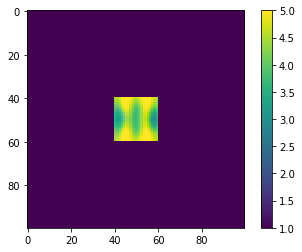

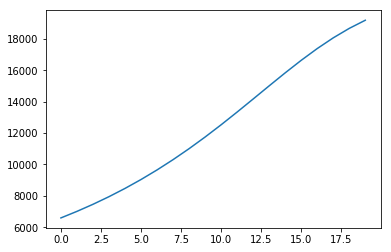

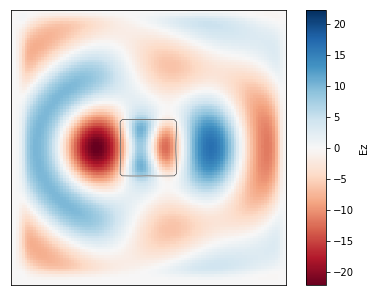

In [26]:
plt.imshow(simulation.eps_r)
plt.colorbar()
plt.show()
plt.plot(obj_fns)
plt.show()
(convergence_array) = _solve_nl(simulation, b, kerr_nonlinearity, regions['nonlin'], kerr_nl_de, solver='newton')
simulation.plt_re(outline=True, cbar=True);

In [27]:
# Now let's try Newton
# Reset simulation
simulation.reset_eps(eps_r)
obj_fns = run_optimization(simulation, 20*b, J, dJdE, Nsteps, eps_max, regions, nonlin_fns=nonlin_fns, field_start='linear', solver='newton', step_size=0.001)

100% (20 of 20) |########################| Elapsed Time: 0:00:15 ETA:  00:00:00

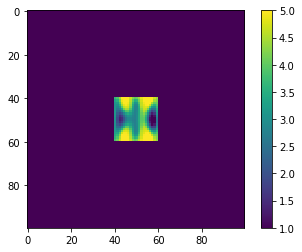

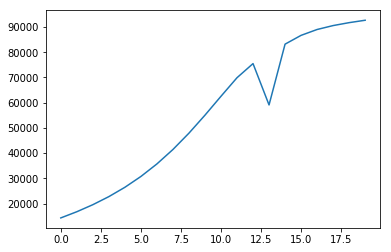

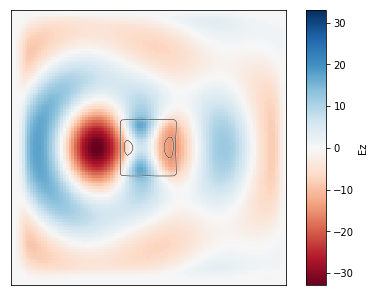

In [29]:
# It is both faster and more stable; still, the results are exactly the same because the Born computation was 
# essentially converged (maximum convergence was still ~1e-6)
plt.imshow(simulation.eps_r)
plt.colorbar()
plt.show()
plt.plot(obj_fns)
plt.show()
(convergence_array) = _solve_nl(simulation, b, kerr_nonlinearity, regions['nonlin'], kerr_nl_de, solver='newton')
simulation.plt_re(outline=True, cbar=True);

In [30]:
# Finally let's try using the "previous" fields instead of starting from the linear solution at every step
# Reset simulation
simulation.reset_eps(eps_r)
# Use Born
Nsteps = 20
obj_fns = run_optimization(simulation, 20*b, J, dJdE, Nsteps, eps_max, regions, nonlin_fns=nonlin_fns, field_start='previous', solver='newton', step_size=0.001)

 80% (16 of 20) |###################     | Elapsed Time: 0:00:13 ETA:   0:00:19

the simulation did not converge, reached 0.08727135787696615


100% (20 of 20) |########################| Elapsed Time: 0:00:16 ETA:  00:00:00

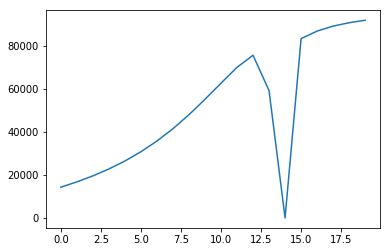

In [33]:
# Similarly (bad) stability and time... results are still the same
plt.plot(obj_fns)
plt.show()

In [34]:
# Reset simulation
simulation.reset_eps(eps_r)
# Use Newton
Nsteps = 20
obj_fns = run_optimization(simulation, 20*b, J, dJdE, Nsteps, eps_max, regions, nonlin_fns=nonlin_fns, field_start='previous', solver='newton', step_size=0.001)

NameError: name 'nl_region' is not defined

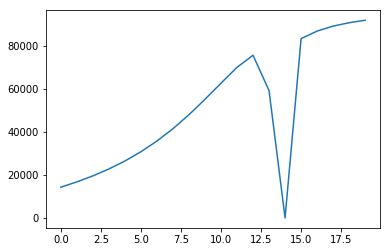

In [35]:
# Interestingly this is actually worse (less stable)... 
# Might be better with a smaller step size, let's leave the option for now
plt.plot(obj_fns)
plt.show()